# Momentum broadening from the 2+1D Glasma at RHIC and LHC

In this notebook we compute the effects of Glasma fields at the pre-equilibrium stage of a heavy-ion collision
on momentum broadening of ultrarelativistic quarks. We use the McLerran-Venugopalan model for our initial conditions. 

The numerical solutions of the Glasma fields are computed using `curraun`, which implements the standard leapfrog solver for boost-invariant Yang-Mills theory in Numba/Phython. `curraun` is also used for computing energy density, pressures and momentum broadening. We start by choosing some settings and importing the necessary packages.

In [1]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su3"
os.environ["PRECISION"] = "double"

# This line is necessary, because cupy otherwise doesn't find
# the cuda installation path.
os.environ["CUDA_PATH"] = "/usr/local/cuda-9.0"

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
import curraun.kappa as kappa
import curraun.qhat as qhat
from curraun.energy import Energy
import curraun.initial as initial
initial.DEBUG = False

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle, datetime
from tqdm import tqdm

import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size':18})

# define hbar * c in units of GeV * fm
hbarc = 0.197326 

Using CUDA
Using SU(3)
Using double precision


To run our simulations we define a Python function that takes a dictionary of parameters as input and returns a dictionary of observables.

In [2]:
def compute(p):    
    # output dictionary
    output = {}
    output["p_qhat"] = []
    output["parameters"] = p.copy()
    
    # derived parameters
    a = p['L'] / p['N']
    E0 = p['N'] / p['L'] * hbarc
    DT = 1.0 / p['DTS']
    maxt = int(p['TMAX'] / a) * p['DTS']
    
    # event loop
    for e in range(p['NE']):
        s = core.Simulation(p['N'], DT, p['G'])
        va = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
        vb = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
        initial.init(s, va, vb)
        
        qhat_tforce = qhat.TransportedForce(s)
        p_qhat = []

        if use_cuda:
            s.copy_to_device()
            qhat_tforce.copy_to_device()
            meminfo = cuda.current_context().get_memory_info()
        
        with tqdm(total=maxt, file=sys.stdout) as pbar:
            for t in range(maxt):
                core.evolve_leapfrog(s)
                
                if t % p['DTS'] == 0:
                    if use_cuda:
                        qhat_tforce.copy_mean_to_host()

                    # unit factors (GeV^2)
                    units = E0 ** 2 / (s.g ** 2)

                    # color factors (for quarks)
                    Nc = core.su.NC
                    f = 2 * s.g ** 2 / (2 * Nc)
                    p_qhat.append(qhat_tforce.p_perp_mean * units * f)
                    
                    if use_cuda:
                        qhat_tforce.copy_mean_to_device()

                qhat_tforce.compute()

                pbar.set_description('Event {:3d} | {:.2f} GB / {:.2f} GB'.format(e,
                                                                                  meminfo[0] / 1024 ** 3,
                                                                                  meminfo[1] / 1024 ** 3))
                pbar.update(1)
        
        p_qhat = np.array(p_qhat)
        output["p_qhat"].append(p_qhat)
    
    # perform average over events
    output["p_qhat_data"] = np.array(output["p_qhat"]).copy()
    output["p_qhat"] = np.mean(output["p_qhat_data"], axis=0)
    output["p_qhat_std"] = np.std(output["p_qhat_data"], axis=0)
    
    # more useful stuff
    output["tau"] = np.linspace(0, p['TMAX'], num=int(p['TMAX'] / a))
    output["E0"] = E0
    
    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    return output

# Large MV model simulations

We run our simulations for a handful of parameter sets. If we fix $g^2 \mu$ and $m$, then our simulations only depend on the ratio $m / (g^2 \mu)$. This way we can run simulations once and then rescale to the desired value of $g^2 \mu$. We use the numerical results of [arXiv:0711.3039](https://arxiv.org/abs/0711.3039), Fig. 4 to convert the results to depend on $Q_s$.

In [4]:
def run_simulation(g2mu, m_ratio, tmax, g, fn):
    print("Running with m = {:3.2f} g^2 \mu".format(m_ratio))
    
    mu = g2mu / g ** 2
    m = m_ratio * g2mu
    L = 100.0 / (g ** 2 * mu) * hbarc
    
    tmax_fm = hbarc * tmax / g2mu
    
    p = {
        'L':    L,               # transverse size [fm]
        'N':    1024,            # lattice size
        'DTS':  16,              # time steps per transverse spacing
        'TMAX': tmax_fm,         # max. proper time (tau) [fm/c]

        'G':    g,               # YM coupling constant
        'MU':   mu,              # MV model parameter [GeV]
        'M':    m,               # IR regulator [GeV]
        'UV':   1000000.0,       # UV regulator [GeV]
        'NS':   50,              # number of color sheets

        'NE':   50,              # number of events
    }
    
    res = compute(p)
    pickle.dump(res, open("./{}.pickle".format(fn), "wb"))

In [ ]:
# Calculate everything for g^2 \mu = 1.0 GeV and use rescaling for other values
g2mu = 1.0

m_ratios =  [0.00, 0.05, 0.10, 0.20]
tmax = 50.0 # measured in (g^2 \mu)^{-1}, corresponds to 4 fm/c for g^2\mu = 1 GeV

for i, mr in enumerate(m_ratios):
    fn = "m_ratio_{:3.2f}_set_3".format(mr)
    m_ratio = mr
    g = 2.0
    print("Output: {}".format(fn))
    run_simulation(g2mu, m_ratio, tmax, g, fn)

# The ratio Qs/(g^2 \mu) ratio depends on m/(g^2 \mu).
# The values extracted visually from arXiv:0711.3039 are:
# m/(g^2 \mu) = 0.00, Qs/(g^2 \mu) = 1.08
# m/(g^2 \mu) = 0.05, Qs/(g^2 \mu) = 0.98
# m/(g^2 \mu) = 0.10, Qs/(g^2 \mu) = 0.85
# m/(g^2 \mu) = 0.20, Qs/(g^2 \mu) = 0.68

# The transverse length of the lattice is chosen 
# to satisfy g^2 \mu L = 100.0 as in arXiv:0711.3039

Qs_ratios = [1.08, 0.98, 0.85, 0.68]

Output: m_ratio_0.00_set_3
Running with m = 0.00 g^2 \mu
Event   0 | 3.57 GB / 11.78 GB: 100%|██████████| 8192/8192 [01:54<00:00, 71.74it/s]
Event   1 | 4.56 GB / 11.78 GB: 100%|██████████| 8192/8192 [01:49<00:00, 74.51it/s]
Event   2 | 4.57 GB / 11.78 GB: 100%|██████████| 8192/8192 [01:49<00:00, 74.53it/s]
Event   3 | 3.56 GB / 11.78 GB: 100%|██████████| 8192/8192 [01:49<00:00, 74.52it/s]
Event   4 | 4.55 GB / 11.78 GB: 100%|██████████| 8192/8192 [01:49<00:00, 74.50it/s]
Event   5 | 4.57 GB / 11.78 GB: 100%|██████████| 8192/8192 [01:49<00:00, 74.51it/s]
Event   6 | 3.56 GB / 11.78 GB: 100%|██████████| 8192/8192 [01:49<00:00, 74.52it/s]
Event   7 | 4.55 GB / 11.78 GB: 100%|██████████| 8192/8192 [01:49<00:00, 74.49it/s]
Event   8 | 4.57 GB / 11.78 GB: 100%|██████████| 8192/8192 [01:49<00:00, 74.53it/s]
Event   9 | 3.56 GB / 11.78 GB: 100%|██████████| 8192/8192 [01:49<00:00, 74.52it/s]
Event  10 | 4.55 GB / 11.78 GB: 100%|██████████| 8192/8192 [01:49<00:00, 74.49it/s]
Event  11 | 4.57 GB

# Load data from files

In [18]:
m_ratios =  [0.00, 0.05, 0.10, 0.20]
fns = ["m_ratio_{:3.2f}_set_3".format(mr) for mr in m_ratios]
ress = []
for fn in fns:
    res = pickle.load(open("./{}.pickle".format(fn), "rb"))
    ress.append(res)

## Plot: $\big<p^2_i\big>/ Q_s^2 $ as a function of $Q_s \tau$

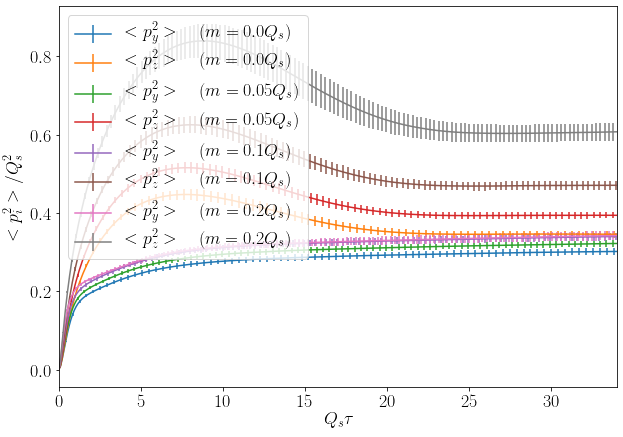

In [19]:
Qs_ratios = [1.08, 0.98, 0.85, 0.68]
for i, r in enumerate(ress):
    g2mu = 1.0
    Qs = Qs_ratios[i] * g2mu
    plt.errorbar(Qs * r["tau"] / hbarc, r["p_qhat"][:, 1] / Qs ** 2, yerr=r["p_qhat_std"][:, 1] / Qs ** 2, fmt='-', errorevery=4)
    plt.errorbar(Qs * r["tau"] / hbarc, r["p_qhat"][:, 2] / Qs ** 2, yerr=r["p_qhat_std"][:, 2] / Qs ** 2, fmt='-', errorevery=4)

m_ratios =  [0.00, 0.05, 0.10, 0.20]

plt.xlabel("$Q_s \\tau$")
plt.ylabel("$<p_i^2> / Q_s^2$")
plt.xlim([0, 34])
legend = [["$<p_y^2> \quad (m = {} Q_s)$".format(m), "$<p_z^2> \quad (m = {} Q_s)$".format(m)] for m in m_ratios]
legend = np.array(legend).flatten()
plt.legend(legend)
plt.show()

In [20]:
# Create some tables for pgfplots
# Reinterpolate to same values of tau
from scipy.interpolate import interp1d

tau_table = np.linspace(0, 34, num=400)
data = [tau_table]
Qs_ratios = [1.08, 0.98, 0.85, 0.68]

for i, r in enumerate(ress):
    g2mu = 1.0
    Qs = Qs_ratios[i] * g2mu
    orig_tau = r["tau"] / hbarc * Qs
    orig_py = r["p_qhat"][:, 1] / Qs ** 2
    orig_pz = r["p_qhat"][:, 2] / Qs ** 2
    
    int_py = interp1d(orig_tau, orig_py)
    int_pz = interp1d(orig_tau, orig_pz)
    
    data.append(int_py(tau_table))
    data.append(int_pz(tau_table))
    data.append(int_py(tau_table) + int_pz(tau_table))

data = np.array(data).T
data = np.nan_to_num(data)
np.savetxt("accumulated_momentum_tau.dat", data, header="Q_s * tau, <p^2_y>/ Q_s, <p^2_z> / Q_s^2, <p^2_\perp> / Q_s^2 (x4)")